In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from scipy import ndimage
from skimage.transform import resize

from utils.eda_utils import *

In [ ]:
DATA_PATH = './semantic_segm_data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')

# EDA

In [ ]:
train = os.listdir(TRAIN_PATH)
val = os.listdir(VAL_PATH)
print(f'N train samples: {len(train)}')
print(f'N val samples: {len(val)}')

N train samples: 2975
N val samples: 500


Построим несоклько случайных примеров из `Train` и `Val`:

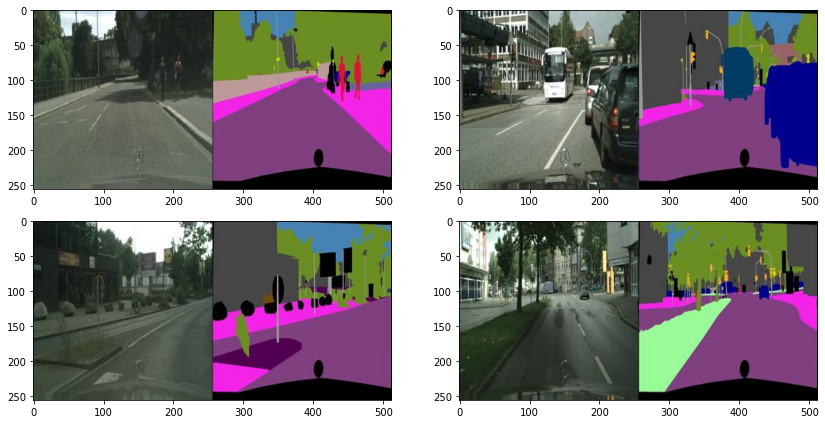

In [ ]:
plot_samples(TRAIN_PATH)

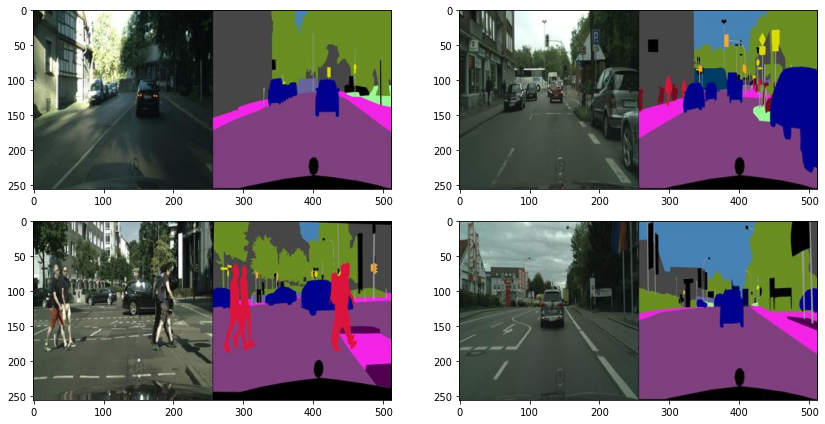

In [ ]:
plot_samples(VAL_PATH)

Для сегментации ['человек', 'машина'] нужно выделить маски по соответствующим цветам. <br> Поскольку картинки из датасета CityScapes, цветовое обозначение лейблов можно найти в репозитории:

In [ ]:
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

labels = {
    'person': (220, 20, 60),
    'rider': (255, 0, 0),
    'car': (0, 0, 142),
    'truck': (0, 0, 70),
    'bus': (0, 60, 100),
    'caravan': (0, 0, 90),
    'trailer': (0, 0, 110)
}

Нужно проверить соответствие лейблов, для этого посмотрим на цвета соответствующе машинам и людям:

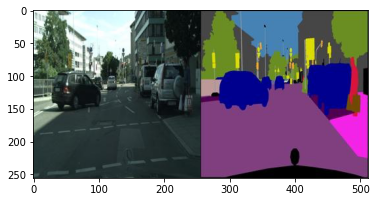

In [ ]:
sample = get_sample(TRAIN_PATH)
plt.imshow(sample)

In [ ]:
points_to_probe = [
                   [100, 300],
                   [115, 330],
                   [100, 490],
                   [110, 490]
]

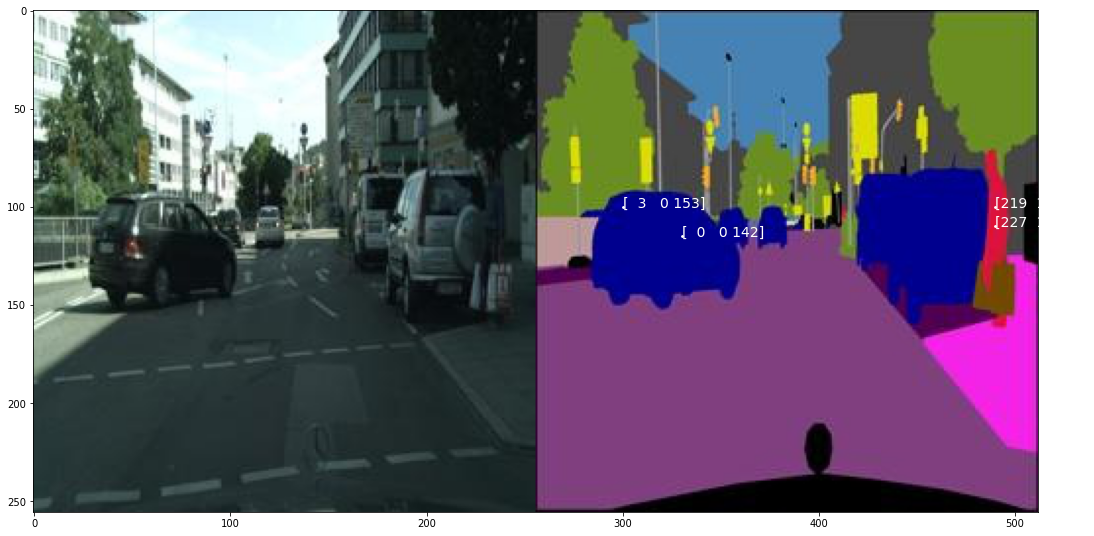

In [ ]:
probe_colors(sample, points_to_probe)

Видно, что цвета близки к ожидаемым, но немного отличаются. Проверим это дополнительно, построив градиенты по цветам. В "идеальном" датасете должны увидеть 0 внутри каждого из классов и не 0 на границах между объектами, если цвета имеют разброс, дожны увидеть не 0 внутри объектов:

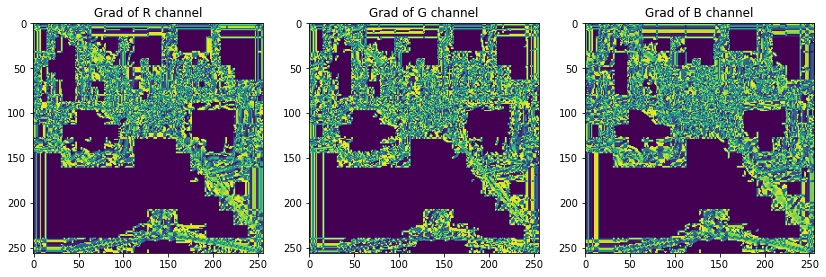

In [ ]:
plot_grads(sample)

Видим разброс по цветам в внутри объектов одного класса. <br>
Вероятно отклонение цветов от исходных произошло в результате сжатия в jpeg и для выделения масок потребуется выбирать цветовой диапазон.

Выберем диапазоны цветов так, чтобы:
* в класс `car` попали `{car, truck, bus, caravan, trailer}`
* в класс `human` попали `{person, rider}`.
* будем выбирать маски из условия попадания цветов в заданные диапазоны. 

In [ ]:
labels_range = {
    'human': [(200, 0, 0), (255, 40, 80)],
    'car': [(0, 0, 60), (20, 70, 160)]
}

Из-за разброса в цветах в масках будет появляться шум, для его снижения можно выполнить эрозию и последующую диляцию:

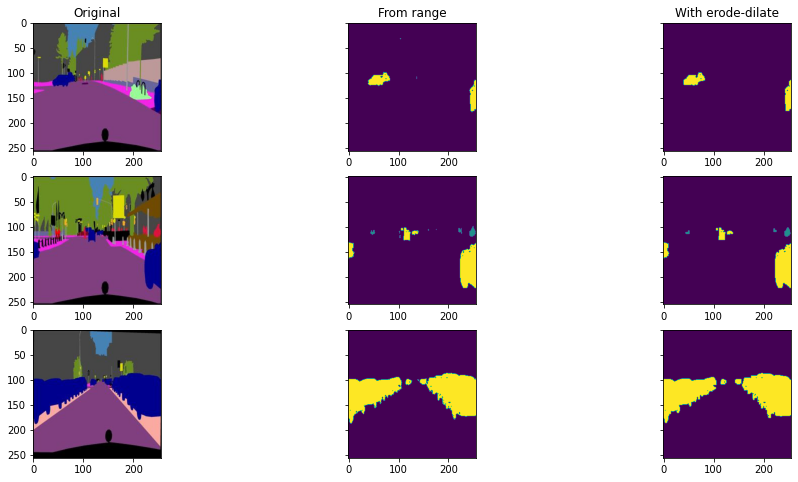

In [ ]:
test_masking(TRAIN_PATH, labels_range)

При обучении моделей будет использоваться таргет с эрозией-диляцией.